In [186]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from numpy.fft import fft, ifft
from IPython.display import Audio

In [187]:
def isVoiced(frame, threshold = 200e7):
    isVoiced = 0

    #### YOUR CODE HERE ####
    sum = 0
    for n in range(len(frame)):
        sum += abs(frame[n])**2

    if sum > threshold:
        isVoiced = 1

    # print("sum: {}".format(sum))
    return isVoiced

# peak detection functions from lab 1 for help

def peak_detection(t, sig):
    """
    Description: Retrieve the max peak from a given array of positions and signal values
    :param t:
    :param sig:
    :return:
    """
    peaks = []
    max_val = -np.Inf
    N = len(sig)

    for i in range(0, N):
        if sig[i] > max_val:
            max_val = sig[i]
            position = t[i]
    peaks.append((position, max_val))
    return np.array(peaks)

def multiple_peak_detection(t, sig, thresh=3):
    """
    Description: For every continuous signal above the specified threshold, retrieve its local maxima
    :param t:
    :param sig:
    :param thresh:
    :return:
    """
    peaks = []
    N = len(sig)

    thresh_indices = np.where(sig > thresh)[0] # retrive all sig indices that are above the threshold
    curr_start = thresh_indices[0] # starting slice
    curr_end = None # ending slice
    for i in range(1, len(thresh_indices)):
        idx = thresh_indices[i]

        # update curr_end if indices are still continuous
        if curr_end is None or idx - 1 == curr_end:
            curr_end = idx
            continue

        # if indices are no longer continuous, process previous continuous signal and then reset curr_start and curr_end
        if curr_end is not None and idx - 1 != curr_end:
            peaks.append(peak_detection(t[curr_start:curr_end], sig[curr_start:curr_end])[0])
            curr_start = idx
            curr_end = None

    return np.array(peaks)

In [188]:
################## YOUR CODE HERE ######################
def ece420ProcessFrame(frame, Fs):
    freq = -1

    voiced = isVoiced(frame)

    if voiced == 0:
        return freq

    result = fft(frame)
    result = np.real(result)**2 + np.imag(result)*np.imag(result)
    result = ifft(result)

    t = np.linspace(0, len(frame)/Fs, len(frame))
    # frequncies = np.linspace(0, fs/2, len(frame))
    peaks = multiple_peak_detection(t, result, 0.5)
    y_peaks = peaks[1:,1]
    
    l = np.argwhere(result == np.max(y_peaks))[0,0]

    freq = Fs / l
    
    return freq

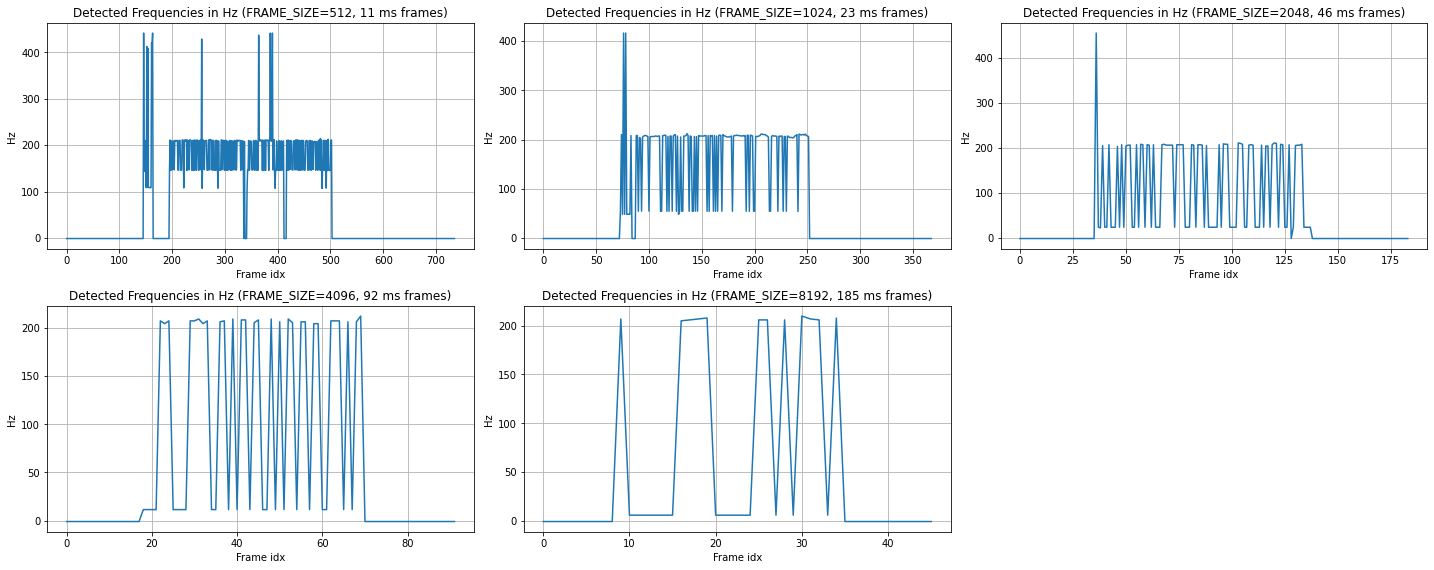

In [189]:
################# GIVEN CODE BELOW #####################

Fs, data = read('test_vector.wav')
duration = len(data) / Fs

frames = [512, 1024, 2048, 4096, 8192]
totalNumFrames = [int(len(data) / frame_size) for frame_size in frames]
totalFrequencies = []

for n in range(len(totalNumFrames)):
    numFrames = totalNumFrames[n]
    currFrame = frames[n]
    frequencies = np.zeros(numFrames)
    for i in range(numFrames):
        frame = data[i * currFrame : (i + 1) * currFrame]
        frequencies[i] = ece420ProcessFrame(frame.astype(float), Fs)
    totalFrequencies.append(frequencies)

fig = plt.figure(figsize=(20,8))

plt.subplot(231)
plt.plot(totalFrequencies[0])
plt.axis('tight')
plt.xlabel('Frame idx')
plt.ylabel('Hz')
plt.title('Detected Frequencies in Hz (FRAME_SIZE={}, {} ms frames)'.format(frames[0], int((frames[0]/Fs)*1000)))
plt.grid(True)

plt.subplot(232)
plt.plot(totalFrequencies[1])
plt.axis('tight')
plt.xlabel('Frame idx')
plt.ylabel('Hz')
plt.title('Detected Frequencies in Hz (FRAME_SIZE={}, {} ms frames)'.format(frames[1], int((frames[1]/Fs)*1000)))
plt.grid(True)

plt.subplot(233)
plt.plot(totalFrequencies[2])
plt.axis('tight')
plt.xlabel('Frame idx')
plt.ylabel('Hz')
plt.title('Detected Frequencies in Hz (FRAME_SIZE={}, {} ms frames)'.format(frames[2], int((frames[2]/Fs)*1000)))
plt.grid(True)

plt.subplot(234)
plt.plot(totalFrequencies[3])
plt.axis('tight')
plt.xlabel('Frame idx')
plt.ylabel('Hz')
plt.title('Detected Frequencies in Hz (FRAME_SIZE={}, {} ms frames)'.format(frames[3], int((frames[3]/Fs)*1000)))
plt.grid(True)

plt.subplot(235)
plt.plot(totalFrequencies[4])
plt.axis('tight')
plt.xlabel('Frame idx')
plt.ylabel('Hz')
plt.title('Detected Frequencies in Hz (FRAME_SIZE={}, {} ms frames)'.format(frames[4], int((frames[4]/Fs)*1000)))
plt.grid(True)

fig.tight_layout(pad=1.0)


In [190]:
Audio(data, rate=Fs)

#### The autocorrelation for speech signals will be periodic with many candidate peaks. How do you decide which peak to use?

We decided which peak to use based on the maximum amplitude since the delay of l that leads to the maximal Rxx value is the one needed for finding the fundamental frequency. We choose this peak though after discarding the first peak since this first peak typically corresponds to l = 0 and leads to bad estimates. We then choose l that correspond to the next maximal peak. 

#### The autocorrelation for any signal will be maximal in the neighborhood surrounding zero lag. How do you decide what to ignore?

We automatically discard the first peak everytime because this will always result in l = 0. Afterwards, we find the maximal peak from the undiscarded peaks. 

#### Why did we choose 40 ms frames?

40 ms frames were chosen because they are a good balance in terms of information and time precision. 40 ms frames are long enough to record information needed for calculating the fundamental frequency/period, and short enough so that we have a good amount of time precision. 